In [2]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from scipy import signal

!wget https://www.cs.cmu.edu/~deva/pics/breakfeast.jpg


--2025-02-07 15:04:46--  https://www.cs.cmu.edu/~deva/pics/breakfeast.jpg
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50115 (49K) [image/jpeg]
Saving to: ‘breakfeast.jpg’

breakfeast.jpg      100%[===================>]  48.94K  --.-KB/s    in 0.04s   

2025-02-07 15:04:47 (1.26 MB/s) - ‘breakfeast.jpg’ saved [50115/50115]



(numpy.ndarray, (307, 410), dtype('float64'))

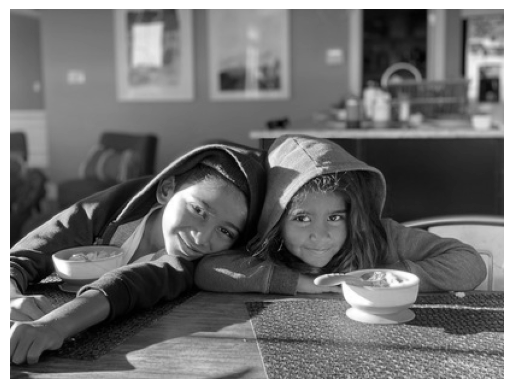

In [3]:
im = plt.imread('breakfeast.jpg')
im = np.mean(im,2)
plt.figure; plt.imshow(im, cmap = 'gray'); plt.axis('off')
type(im), np.shape(im), im.dtype

### Part 1: Blur with naive box filter
---

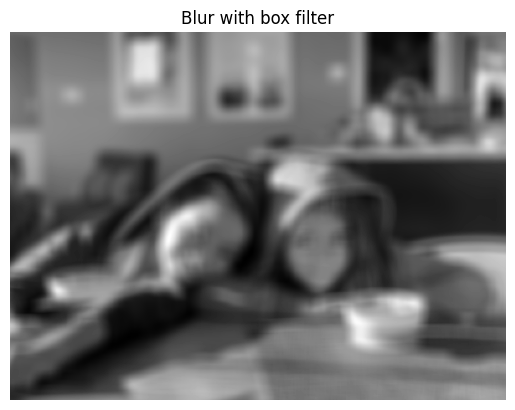

In [4]:
n = 11;  # Try with small (n = 5) and large filters (n=11); does naive averaging or Gaussian blurring look better?
F = np.ones((n,n))
boxres = signal.convolve2d(im,F,mode='valid')
plt.figure; plt.imshow(boxres, cmap = 'gray'); plt.axis('off'); plt.title('Blur with box filter')

### Part 2: Blurring with Gaussian



---



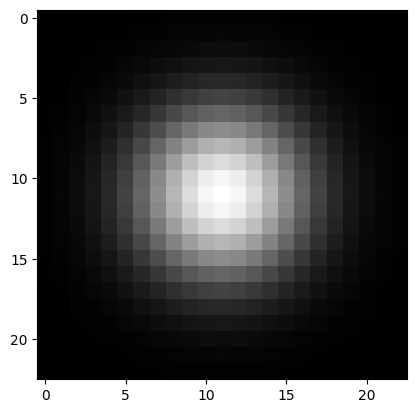

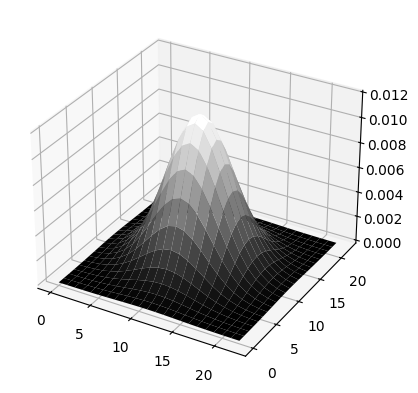

In [5]:
def gaussian2d(size=2, sigma=1):
    # Define 1d gaussian, outerproduct with itself, and normalize to sum-to-1
    x = np.ogrid[-size:size+1]
    g = np.exp( -(x*x) / (2*sigma*sigma) )
    g = np.outer(g,g)
    g = g / np.sum(g)
    return g

g = gaussian2d(n,n/3); #Set sigma equal to a third of the size of the box filter, following the rule that 99% of density falls in 3sigma
Y, X = np.mgrid[0:g.shape[0],0:g.shape[1]]
plt.imshow(g,cmap='gray')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, g, cmap = 'gray')

Text(0.5, 1.0, 'Blur with Gaussian')

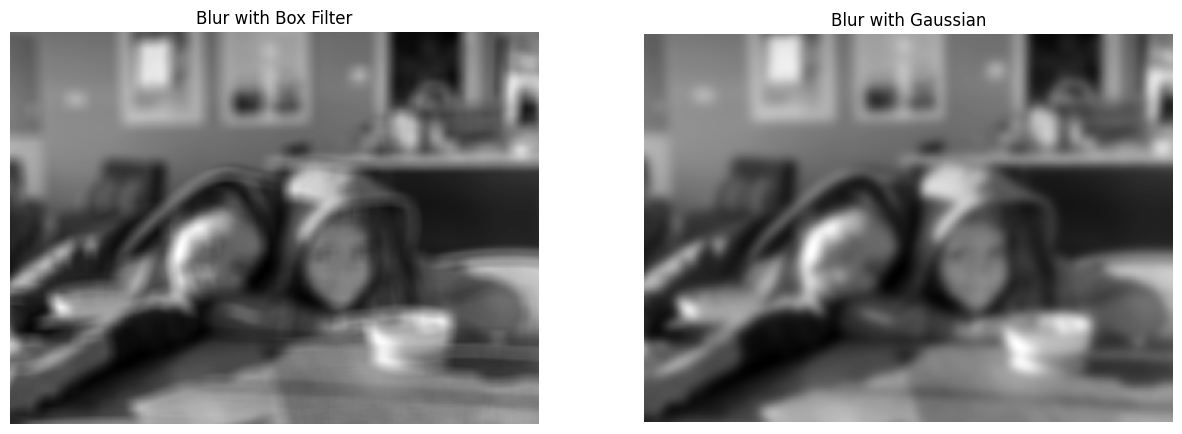

In [6]:
# Blur with Gaussian
gaussres = signal.convolve2d(im,g,mode='valid')
plt.figure(figsize=(15,15))
plt.subplot(121); plt.imshow(boxres, cmap = 'gray'); plt.axis('off'); plt.title('Blur with Box Filter')
plt.subplot(122); plt.imshow(gaussres, cmap = 'gray'); plt.axis('off'); plt.title('Blur with Gaussian')

### Part 3: Convolution from scratch
---


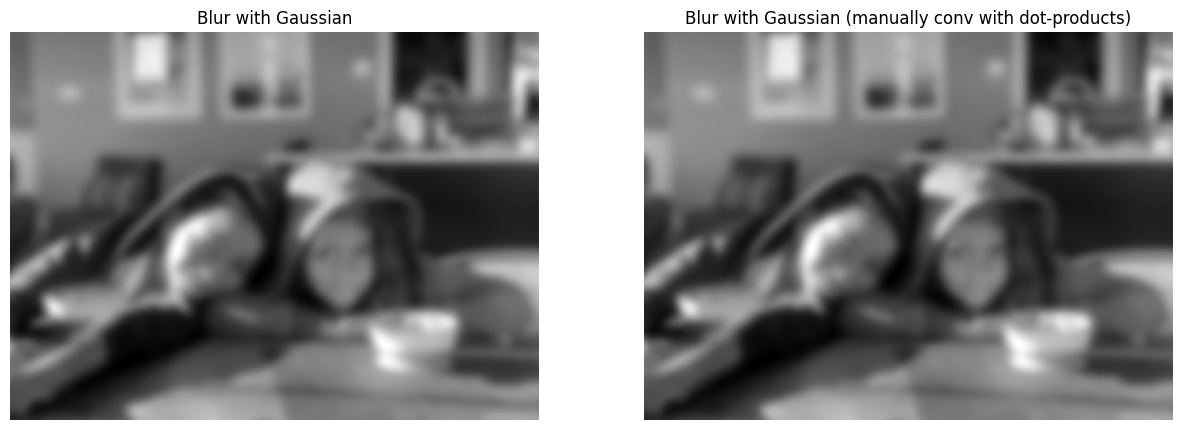

In [7]:
def convolve2d(image, filter):
    # Perform 2D convolution with 'valid'-size output
    # using vector dot products
    ny, nx = image.shape
    my, mx = filter.shape

    # Define output
    oy  = ny - my + 1
    ox  = nx - mx + 1
    res = np.zeros((oy,ox))

    #Flip filter left-right and up-down
    filter = filter[::-1,::-1]

    #Turn filter into a vector
    filter = filter.flatten()

    for i in range(oy):
      for j in range(ox):
        res[i,j] = np.dot(filter,image[i:i+my, j:j+mx].flatten())
    return res


myres = convolve2d(im,g) #Question: how does one turn convolve2D into correlate2D?
plt.figure(figsize=(15,15))
plt.subplot(121); plt.imshow(gaussres, cmap = 'gray'); plt.axis('off'); plt.title('Blur with Gaussian');
plt.subplot(122); plt.imshow(myres, cmap = 'gray'); plt.axis('off'); plt.title('Blur with Gaussian (manually conv with dot-products)');

### Part 3: Computing x derivative and y derivatives

---



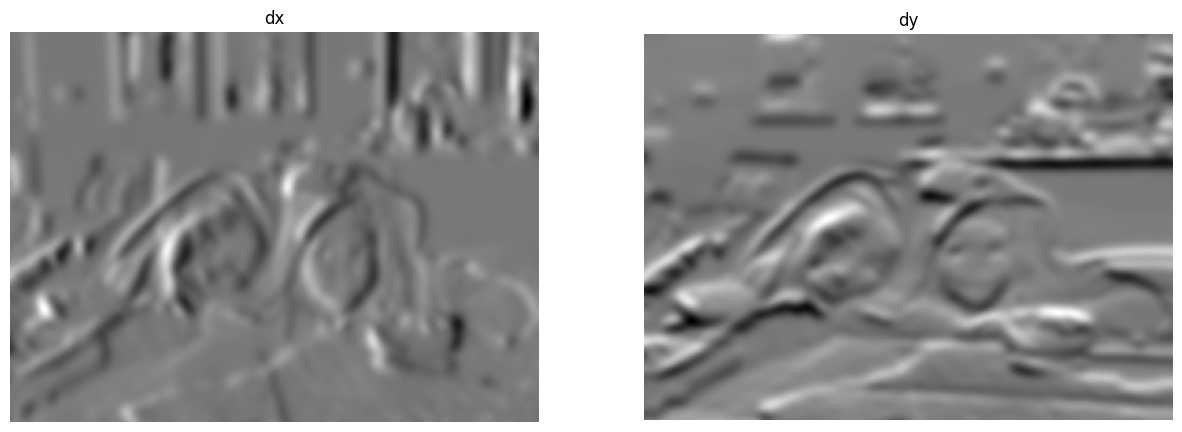

In [ ]:
# Compute gradients with finite differencing
res = myres;
#res = im; #Gradients computed on unsmoothed images should be noisier
d   = np.array([1,0,-1],ndmin=2); # Make sure to define a 2D array
fx  = signal.convolve2d(res,d,mode='valid');
fy  = signal.convolve2d(res,d.T,mode='valid');
plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(fx, cmap = 'gray'); plt.title('dx'); plt.axis('off');
plt.subplot(1,2,2); plt.imshow(fy, cmap = 'gray'); plt.title('dy'); plt.axis('off');


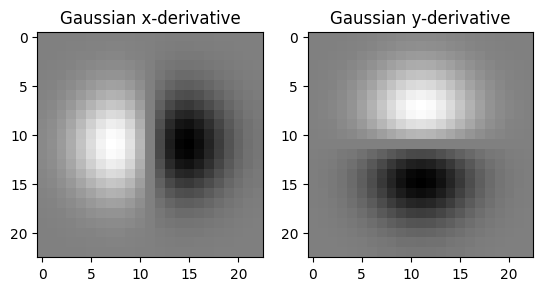

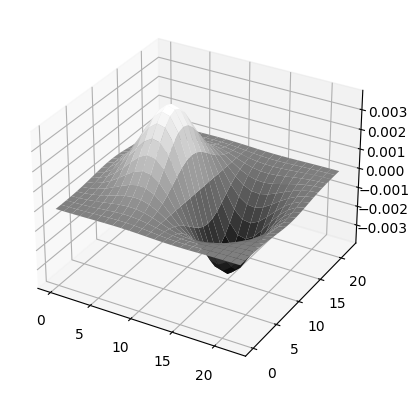

In [ ]:
# Compute with derivative-of-Gaussian filter
#n = 11;
g = gaussian2d(n,n/3);
d  = np.array([1,0,-1],ndmin=2);
gx = signal.convolve2d(g,d,mode='same');
gy = signal.convolve2d(g,d.T,mode='same');
plt.subplot(121); plt.imshow(gx,cmap='gray'); plt.title('Gaussian x-derivative')
plt.subplot(122); plt.imshow(gy,cmap='gray'); plt.title('Gaussian y-derivative')

Y, X = np.mgrid[0:gx.shape[0],0:gx.shape[1]]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, gx, cmap = 'gray');


## Convolution with a filter bank
---

(285, 388, 2)

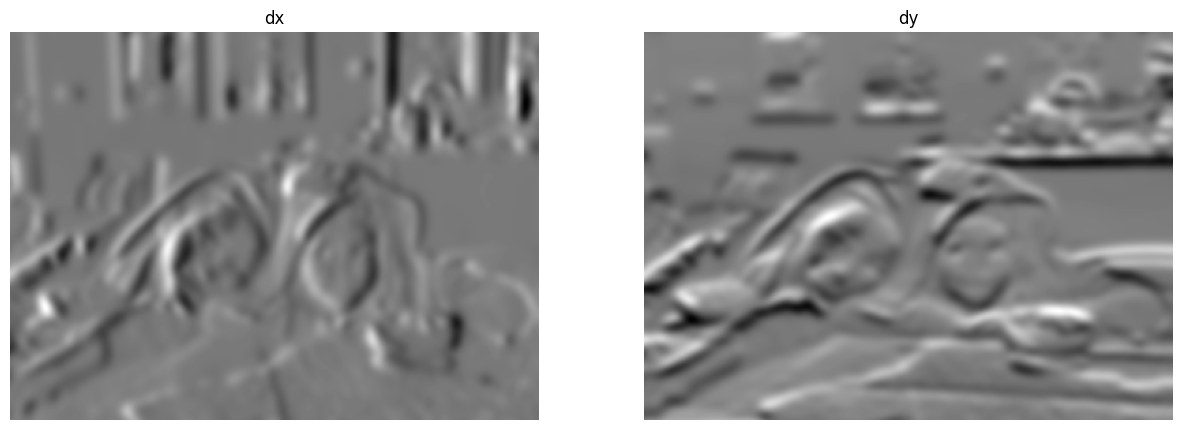

In [ ]:
def convolve2DFilters(image, filters):
    # Perform 2D convolution on filter bank
    # using matrix-vector multiplication
    ny, nx = image.shape
    my, mx, mz = filters.shape

    # Define output
    oy  = ny - my + 1
    ox  = nx - mx + 1
    res = np.zeros((oy,ox,mz))

    #Flip filters left-right and up-down
    filters = filters[::-1,::-1]

    #Reshape filter into 2D matrix
    filters = filters.reshape(my*mx,mz)

    for i in range(oy):
      for j in range(ox):
        res[i,j,:] = image[i:i+my, j:j+mx].reshape(1,my*mx)@filters
    return res

res = convolve2DFilters(im,np.dstack((gx,gy)))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(res[:,:,0], cmap = 'gray'); plt.title('dx'); plt.axis('off');
plt.subplot(1,2,2); plt.imshow(res[:,:,1], cmap = 'gray'); plt.title('dy'); plt.axis('off');
res.shape
